In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from IPython.display import HTML

from data_funcs_and_classes import AnimatedScatter, generate_data, UMIDataset
from model_classes import UMINN_Jacobi_2

In [2]:
data, labels = generate_data()

loader = DataLoader(UMIDataset(torch.from_numpy(data), torch.from_numpy(labels)), batch_size=32, shuffle=True)

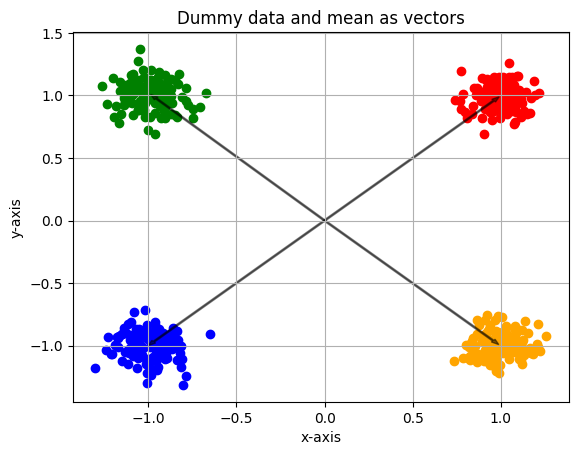

In [3]:
plt.close()
fig, ax = plt.subplots(1)#, sharex='col', sharey='row', gridspec_kw={'wspace': 0})

colors = ['red','green','blue','orange']
means = np.mean(np.reshape(data,(4,int(data.shape[0]/4),data.shape[-1])),axis=1)
cluster_N = int(data.shape[0] / 4)
for color,mean,i in zip(colors,means,range(len(colors))):
    ax.scatter(data[i*cluster_N:(i+1)*cluster_N,0],data[i*cluster_N:(i+1)*cluster_N,1],color=color)
    ax.arrow(0,0,mean[0],mean[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))
plt.title('Dummy data and mean as vectors')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
ax.grid('on')

In [4]:
def train(dl, model, lr = 0.01, n_epochs = 2, svb = False):
    losses = []
    epochs = []
    weights = []
    i = 0
    while ((i < 26) or ((np.min(losses[-25:]) - np.max(losses[-25:])) < 0.01)) and (i < n_epochs):
    #print(f"Epoch {epoch+1}")
        N = len(loader)
        for param in model.parameters():
            weights.append(param.detach().numpy().copy())
        for j, (data, labels) in enumerate(loader):
            epochs.append(i + j/N)
            loss_data = model.train_step(data, labels)
            losses.append(loss_data)
        if svb:
            model.svb

        i += 1
    return losses, epochs, weights


c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\_functorch\deprecated.py:85: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')
c:\ProgramData\Anaconda3\envs\bioai\Lib\site-packages\torch\_functorch\deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


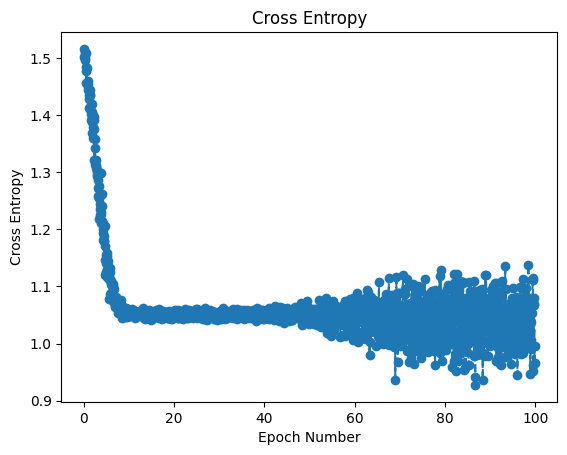

In [5]:
model = UMINN_Jacobi_2(lmbd = 0.0001)
lr = 0.001
n_epochs = 100
losses, epochs, weights = train(loader, model, lr, n_epochs)

plt.plot(epochs, losses, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
_ = plt.title('Cross Entropy')

In [6]:
print(weights[-1])

[[ 1.6724072   1.66968   ]
 [-0.22748353  0.26969635]
 [-1.6723508  -1.6720257 ]
 [ 0.22813065 -0.26619056]]


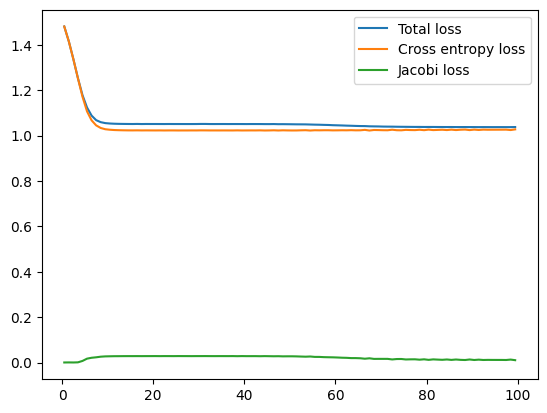

In [7]:
epoch_data_avgd = np.array(epochs).reshape(100,-1).mean(axis=1) # the number in reshape has to divide the number of epochs
loss_data_avgd = np.array(losses).reshape(100,-1).mean(axis=1)

plt.plot(epoch_data_avgd,loss_data_avgd, label="Total loss") # Plot the average loss per epoch

crossloss_data_avgd = np.array(model.cross_losses[:]).reshape(100,-1).mean(axis=1)
jacobiloss_data_avgd = np.array(model.jacobi_losses[:]).reshape(100,-1).mean(axis=1)
plt.plot(epoch_data_avgd,crossloss_data_avgd,label="Cross entropy loss") # Plot the average loss per epoch
plt.plot(epoch_data_avgd,jacobiloss_data_avgd, label="Jacobi loss") # Plot the average loss per epoch
# plt.plot(epoch_data,loss_data)

plt.legend()

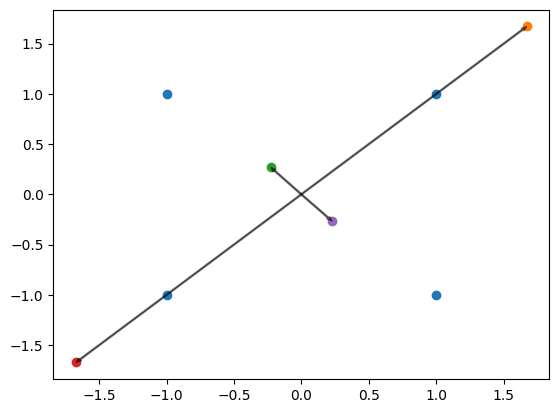

In [8]:
plt.scatter([-1, -1, 1, 1], [1, -1, 1, -1])
for point in weights[-1]:
    plt.scatter(point[0], point[1])
    plt.arrow(0, 0, point[0], point[1], length_includes_head=True,width=0.01,color=(0,0,0,0.5))

In [9]:
test_data, test_labels = generate_data()
#print(model(torch.tensor(test_data)).argmax(dim=1))
#print(torch.tensor(test_labels))
acc = (model(torch.tensor(test_data)).argmax(dim=1) == torch.tensor(test_labels)).float().sum().item()/len(test_labels)
print(acc)

0.986328125


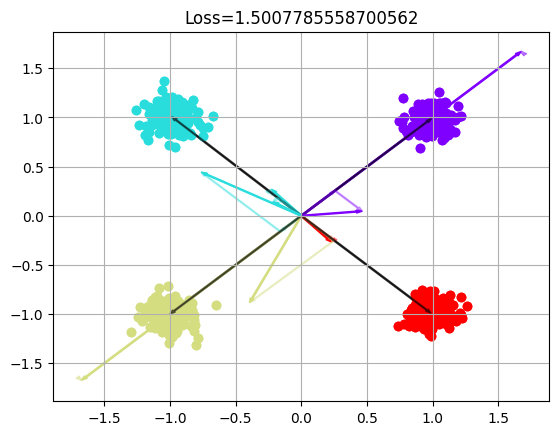

In [10]:
animated_scatter = AnimatedScatter(data, np.array(weights).transpose([0, 2, 1]), losses[::16], n_clusters = 4)
html_object = HTML(animated_scatter.animation.to_html5_video())
html_object